# Задача тематическое моделирование

скачать данные из Роспотребнадзора 
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать 
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

# Импорты

In [21]:
import pandas as pd
import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm
import re
import nltk
from nltk.corpus import stopwords
import pymorphy2

from gensim.models import *
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

import matplotlib.pyplot as plt
%matplotlib inline

# Load data from https://zpp.rospotrebnadzor.ru

In [8]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

domain = 'https://zpp.rospotrebnadzor.ru'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text

urls = []

for page in tqdm(range(1, 500), desc='Pages'):
    time.sleep(0.1)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/499 [00:00<?, ?it/s]

In [13]:
question = []

for url in tqdm(urls, desc='Question pages'):
    time.sleep(0.3)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    question.append(get_text_page_question(soup))

Pages:   0%|          | 0/2495 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame(columns=['question'], data=question)
df.head(2)

,question
0,"У меня в теле 2 тариф 40 гб, 50 смс и 500 мину..."
1,Добрый день!\r\nПо всей стране вспышки простуд...


In [15]:
df.shape

(2495, 1)

## Save source data

In [16]:
df.to_csv('question.csv')

# Preprocessing

In [9]:
df = pd.read_csv('question.csv')

In [10]:
words_regex = re.compile('\w+')

nltk.download('stopwords')

morph = pymorphy2.MorphAnalyzer()

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
C:\Users\Admin\AppData\Local\Temp\ipykernel_3068\3456241982.py:1: DeprecationWarning: invalid escape sequence \w
  words_regex = re.compile('\w+')
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Admin\anaconda3\envs\tf\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Admin\anaconda3\envs\tf\lib\site-packages\pymorphy2\units\base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
C:\Users\Admin\anaconda3\envs\tf\lib\site-packages\

In [11]:
preprocessed_text = list(tqdm(map(preprocess, df['question']), total=len(df)))

  0%|          | 0/2495 [00:00<?, ?it/s]

In [12]:
df['text'] = preprocessed_text

# Модель LDA

создадим словарь:

In [13]:
dictionary = corpora.Dictionary(df['text'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('question.dict')

Векторизуем документы:

In [14]:
corpus = [dictionary.doc2bow(text) for text in df['text']]
corpora.MmCorpus.serialize('ros.model', corpus) 

Обучим модель:

In [15]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: total: 1.8 s
Wall time: 1.81 s


Получившиеся темы:

In [16]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(16,
  '0.190*"ребёнок" + 0.075*"нужно" + 0.064*"второй" + 0.053*"область" + 0.049*"группа" + 0.048*"московский" + 0.030*"подобный" + 0.030*"орган" + 0.028*"постоянно" + 0.023*"граница"'),
 (18,
  '0.047*"право" + 0.044*"постановление" + 0.043*"иметь" + 0.043*"гражданин" + 0.041*"закон" + 0.037*"находиться" + 0.033*"основание" + 0.030*"область" + 0.026*"муж" + 0.025*"установить"'),
 (2,
  '0.090*"услуга" + 0.084*"договор" + 0.049*"потребитель" + 0.042*"право" + 0.034*"ооо" + 0.029*"продажа" + 0.027*"защита" + 0.024*"связь" + 0.019*"условие" + 0.018*"отказ"'),
 (1,
  '0.281*"билет" + 0.102*"находиться" + 0.085*"яндекс" + 0.056*"мероприятие" + 0.040*"перенести" + 0.036*"фирма" + 0.032*"называть" + 0.028*"концерт" + 0.026*"организатор" + 0.025*"годность"'),
 (0,
  '0.123*"документ" + 0.101*"предоставить" + 0.096*"пункт" + 0.056*"выдача" + 0.041*"заключение" + 0.036*"произойти" + 0.036*"нужный" + 0.031*"дать" + 0.024*"соблюдение" + 0.023*"мебель"'),
 (7,
  '0.267*"магазин" + 0.107*"товар"

In [17]:
%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\Users\Admin\anaconda3\envs\tf\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


CPU times: total: 672 ms
Wall time: 5.66 s


## Метрика

In [20]:
coherence_model_lda = CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.35898312863840875


## Подобрать оптимальное количество тем, опираясь на значение метрик:

  0%|          | 0/5 [00:00<?, ?it/s]

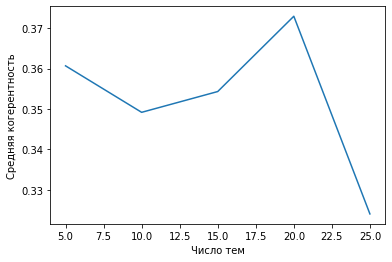

In [23]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['text'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

In [26]:
lda_5 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=5, chunksize=50, update_every=1, passes=2)
lda_20 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

In [27]:
vis_data = gensimvis.prepare(lda_20, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\Users\Admin\anaconda3\envs\tf\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [28]:
vis_data = gensimvis.prepare(lda_5, corpus, dictionary)
pyLDAvis.display(vis_data)

C:\Users\Admin\anaconda3\envs\tf\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
